In [1]:
# step2_pairwise_eda.py

import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# ============================================================
# 0. Path & Load
# ============================================================
BASE_DIR = Path.cwd().resolve()
MONTHLY_PATH = BASE_DIR.parents[1] / "data" / "processed" / "train_monthly_v2.csv"

print(f"[INFO] Loading monthly data from: {MONTHLY_PATH}")
monthly = pd.read_csv(MONTHLY_PATH)

# 예상 컬럼:
# item_id, year, month, type, hs4, total_value, total_weight, total_quantity, ...
print("[INFO] monthly shape:", monthly.shape)
print("[INFO] monthly columns:", monthly.columns.tolist())



[INFO] Loading monthly data from: /data/ephemeral/home/data/processed/train_monthly_v2.csv
[INFO] monthly shape: (3776, 17)
[INFO] monthly columns: ['item_id', 'type', 'hs4', 'hs3', 'hs2', 'year', 'month', 'total_value', 'total_weight', 'total_quantity', 'flag_v0_wpos', 'flag_w0_vpos', 'log_value', 'log_weight', 'log_quantity', 'wv_ratio', 'cluster_wv']


In [3]:
# ============================================================
# 1. Time index & pivot (item x time)
# ============================================================

# year, month -> 연속된 time index (0 ~ T-1)
min_year = monthly["year"].min()
monthly["time_idx"] = (monthly["year"] - min_year) * 12 + (monthly["month"] - 1)

# 정렬
monthly = monthly.sort_values(["item_id", "time_idx"])

# 피벗: item x time_idx
value_pivot = (
    monthly
    .pivot_table(index="item_id", columns="time_idx", values="total_value", aggfunc="sum")
    .fillna(0.0)
)
weight_pivot = (
    monthly
    .pivot_table(index="item_id", columns="time_idx", values="total_weight", aggfunc="sum")
    .fillna(0.0)
)

items = value_pivot.index.tolist()
n_items, n_periods = value_pivot.shape
print(f"[INFO] item count: {n_items}, time length: {n_periods}")

# 메타데이터 (hs4, type, optional: cluster_wv)
meta_cols = ["item_id", "hs4", "type"]
if "cluster_wv" in monthly.columns:
    meta_cols.append("cluster_wv")

item_meta = (
    monthly[meta_cols]
    .drop_duplicates("item_id")
    .set_index("item_id")
)

# hs2, hs3 생성
item_meta["hs4"] = item_meta["hs4"].astype(str).str.zfill(4)
item_meta["hs3"] = item_meta["hs4"].str[:3]
item_meta["hs2"] = item_meta["hs4"].str[:2]

print("[INFO] item_meta head:")
print(item_meta.head())




[INFO] item count: 100, time length: 43
[INFO] item_meta head:
           hs4  type  cluster_wv  hs3 hs2
item_id                                  
AANGBULD  4810     1           3  481  48
AHMDUILJ  2102     1           1  210  21
ANWUJOKX  4403     1           1  440  44
APQGTRMF  8105     1           1  810  81
ATLDMDBO  2814     1           0  281  28


In [4]:
# ============================================================
# 2. Helper functions (z-score, DTW, lag-corr, sign agreement)
# ============================================================
def zscore_matrix(mat):
    """Row-wise z-score (each row: one item)."""
    mat = np.asarray(mat, dtype=float)
    mean = mat.mean(axis=1, keepdims=True)
    std = mat.std(axis=1, keepdims=True) + 1e-8
    return (mat - mean) / std


def dtw_distance(x, y):
    """Simple DTW distance (O(T^2)). T is about 40, so OK for ~5k pairs."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n, m = len(x), len(y)
    dp = np.full((n + 1, m + 1), np.inf)
    dp[0, 0] = 0.0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(x[i - 1] - y[j - 1])
            dp[i, j] = cost + min(dp[i - 1, j], dp[i, j - 1], dp[i - 1, j - 1])
    return dp[n, m]


def max_lag_correlation(x, y, max_lag=3):
    """Return (max_corr, lag_at_max_corr), lag>0 means x leads y."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    # normalize
    x = (x - x.mean()) / (x.std() + 1e-8)
    y = (y - y.mean()) / (y.std() + 1e-8)

    T = len(x)
    full = np.correlate(x, y, mode="full") / T
    lags_all = np.arange(- (T - 1), T)
    mid = len(full) // 2

    mask = (lags_all >= -max_lag) & (lags_all <= max_lag)
    corr_sel = full[mask]
    lags_sel = lags_all[mask]

    idx = np.argmax(corr_sel)
    return corr_sel[idx], int(lags_sel[idx])


def sign_agreement_ratio(diff_x, diff_y):
    """Proportion of time steps where diff signs are same."""
    sx = np.sign(diff_x)
    sy = np.sign(diff_y)
    return (sx == sy).mean()




In [5]:
# ============================================================
# 3. Precompute item-level matrices for similarity
# ============================================================

val_mat = value_pivot.values
wgt_mat = weight_pivot.values

val_z = zscore_matrix(val_mat)
wgt_z = zscore_matrix(wgt_mat)

# diff for sign
val_diff = np.diff(val_mat, axis=1)
wgt_diff = np.diff(wgt_mat, axis=1)

print("[INFO] Precomputed z-scores and diffs.")


[INFO] Precomputed z-scores and diffs.


In [6]:
# ============================================================
# 4. All item pairs + W1~W7 computation
# ============================================================

pairs = list(itertools.combinations(range(n_items), 2))
print(f"[INFO] Total pairs: {len(pairs)}")

rows = []
max_lag = 3

for idx, (i, j) in enumerate(pairs, 1):
    item_i = items[i]
    item_j = items[j]

    # time series
    v_i, v_j = val_z[i], val_z[j]
    w_i, w_j = wgt_z[i], wgt_z[j]

    # W1/W2 cosine similarity
    cos_val = float(np.dot(v_i, v_j) / (np.linalg.norm(v_i) * np.linalg.norm(v_j) + 1e-8))
    cos_wgt = float(np.dot(w_i, w_j) / (np.linalg.norm(w_i) * np.linalg.norm(w_j) + 1e-8))

    # W3 sign agreement on value diff
    sa_val = float(sign_agreement_ratio(val_diff[i], val_diff[j]))

    # W4 cross-correlation (value series)
    cc_val, lag_val = max_lag_correlation(val_mat[i], val_mat[j], max_lag=max_lag)

    # W5 DTW distance on raw value series (log1p optional)
    v_i_log = np.log1p(val_mat[i])
    v_j_log = np.log1p(val_mat[j])
    dist_dtw = float(dtw_distance(v_i_log, v_j_log))
    sim_dtw = 1.0 / (1.0 + dist_dtw)

    # W6 HS distance
    meta_i = item_meta.loc[item_i]
    meta_j = item_meta.loc[item_j]

    hs4_i, hs4_j = meta_i["hs4"], meta_j["hs4"]
    hs3_i, hs3_j = meta_i["hs3"], meta_j["hs3"]
    hs2_i, hs2_j = meta_i["hs2"], meta_j["hs2"]

    if hs4_i == hs4_j:
        hs_dist = 0
    elif hs3_i == hs3_j:
        hs_dist = 1
    elif hs2_i == hs2_j:
        hs_dist = 2
    else:
        hs_dist = 3

    # W7 cluster similarity (if exists)
    if "cluster_wv" in item_meta.columns:
        c_i = meta_i["cluster_wv"]
        c_j = meta_j["cluster_wv"]
        same_cluster = int((c_i == c_j) and (c_i != -1) and (c_j != -1))
        cluster_i = c_i
        cluster_j = c_j
    else:
        same_cluster = np.nan
        cluster_i = np.nan
        cluster_j = np.nan

    rows.append(
        dict(
            item_i=item_i,
            item_j=item_j,
            cos_val=cos_val,
            cos_wgt=cos_wgt,
            sign_agree_val=sa_val,
            cc_val=cc_val,
            lag_val=lag_val,
            dtw_dist=dist_dtw,
            dtw_sim=sim_dtw,
            hs_dist=hs_dist,
            hs4_i=hs4_i,
            hs4_j=hs4_j,
            hs3_i=hs3_i,
            hs3_j=hs3_j,
            hs2_i=hs2_i,
            hs2_j=hs2_j,
            cluster_i=cluster_i,
            cluster_j=cluster_j,
            same_cluster=same_cluster,
        )
    )

    if idx % 500 == 0:
        print(f"[INFO] processed pairs: {idx}/{len(pairs)}")

pair_df = pd.DataFrame(rows)
print("[INFO] pair_df shape:", pair_df.shape)
print(pair_df.head())




[INFO] Total pairs: 4950
[INFO] processed pairs: 500/4950
[INFO] processed pairs: 1000/4950
[INFO] processed pairs: 1500/4950
[INFO] processed pairs: 2000/4950
[INFO] processed pairs: 2500/4950
[INFO] processed pairs: 3000/4950
[INFO] processed pairs: 3500/4950
[INFO] processed pairs: 4000/4950
[INFO] processed pairs: 4500/4950
[INFO] pair_df shape: (4950, 19)
     item_i    item_j   cos_val   cos_wgt  sign_agree_val    cc_val  lag_val  \
0  AANGBULD  AHMDUILJ  0.042443 -0.003717        0.452381  0.042443        0   
1  AANGBULD  ANWUJOKX -0.172992 -0.175872        0.190476 -0.033345       -3   
2  AANGBULD  APQGTRMF -0.050531 -0.105661        0.404762  0.017158       -2   
3  AANGBULD  ATLDMDBO -0.238484  0.215972        0.404762 -0.071796       -2   
4  AANGBULD  AXULOHBQ -0.252488 -0.212871        0.452381 -0.123092        2   

     dtw_dist   dtw_sim  hs_dist hs4_i hs4_j hs3_i hs3_j hs2_i hs2_j  \
0  190.476273  0.005223        3  4810  2102   481   210    48    21   
1  126.64414

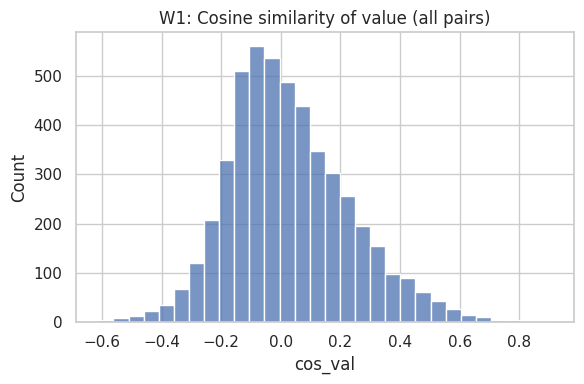

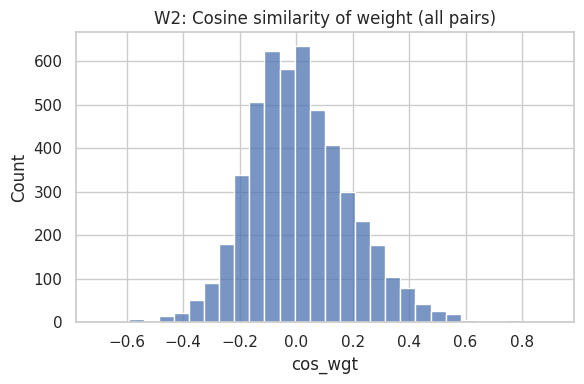

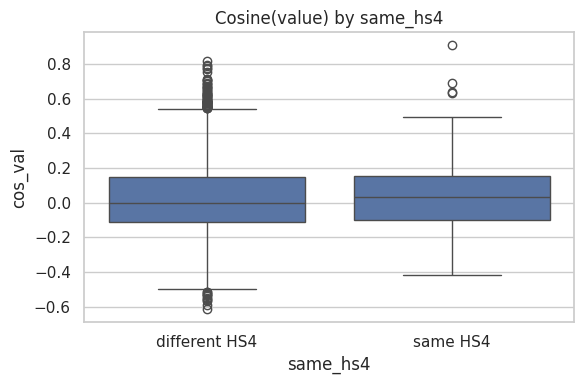

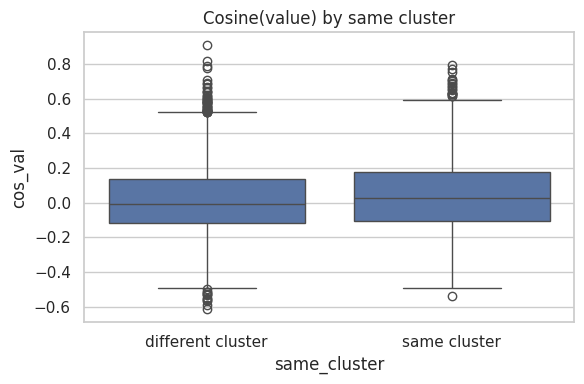

In [7]:
# ============================================================
# 5. EDA for W1/W2 (cosine similarity)
# ============================================================
sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 100})

plt.figure(figsize=(6, 4))
sns.histplot(pair_df["cos_val"], bins=30, kde=False)
plt.title("W1: Cosine similarity of value (all pairs)")
plt.xlabel("cos_val")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(pair_df["cos_wgt"], bins=30, kde=False)
plt.title("W2: Cosine similarity of weight (all pairs)")
plt.xlabel("cos_wgt")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# HS4 동일 여부
pair_df["same_hs4"] = (pair_df["hs4_i"] == pair_df["hs4_j"]).astype(int)

plt.figure(figsize=(6, 4))
sns.boxplot(x="same_hs4", y="cos_val", data=pair_df)
plt.title("Cosine(value) by same_hs4")
plt.xticks([0, 1], ["different HS4", "same HS4"])
plt.tight_layout()
plt.show()

if "same_cluster" in pair_df.columns and not pair_df["same_cluster"].isna().all():
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="same_cluster", y="cos_val", data=pair_df)
    plt.title("Cosine(value) by same cluster")
    plt.xticks([0, 1], ["different cluster", "same cluster"])
    plt.tight_layout()
    plt.show()




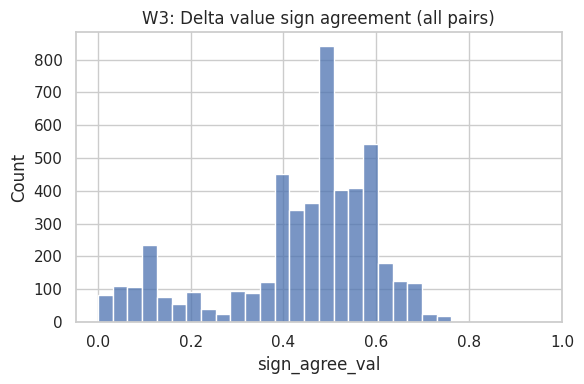

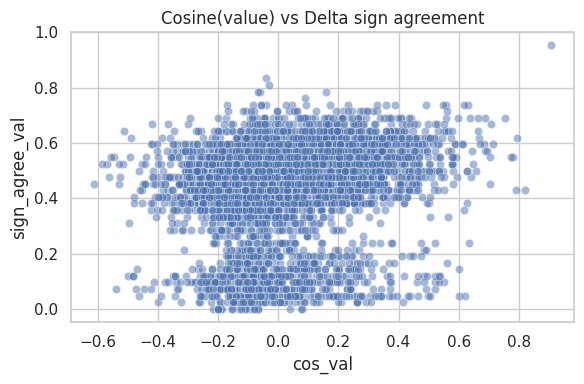

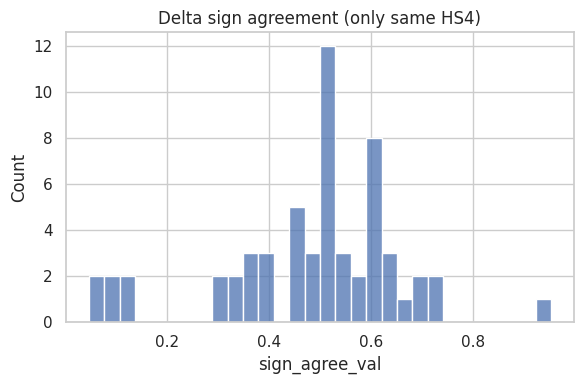

In [8]:
# ============================================================
# 6. EDA for W3 (Delta sign agreement)
# ============================================================

plt.figure(figsize=(6, 4))
sns.histplot(pair_df["sign_agree_val"], bins=30)
plt.title("W3: Delta value sign agreement (all pairs)")
plt.xlabel("sign_agree_val")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# sign agreement vs cosine
plt.figure(figsize=(6, 4))
sns.scatterplot(x="cos_val", y="sign_agree_val", data=pair_df, alpha=0.5)
plt.title("Cosine(value) vs Delta sign agreement")
plt.xlabel("cos_val")
plt.ylabel("sign_agree_val")
plt.tight_layout()
plt.show()

# HS4 내부에서만 sign agreement 분포
plt.figure(figsize=(6, 4))
sns.histplot(pair_df.loc[pair_df["same_hs4"] == 1, "sign_agree_val"], bins=30)
plt.title("Delta sign agreement (only same HS4)")
plt.xlabel("sign_agree_val")
plt.tight_layout()
plt.show()




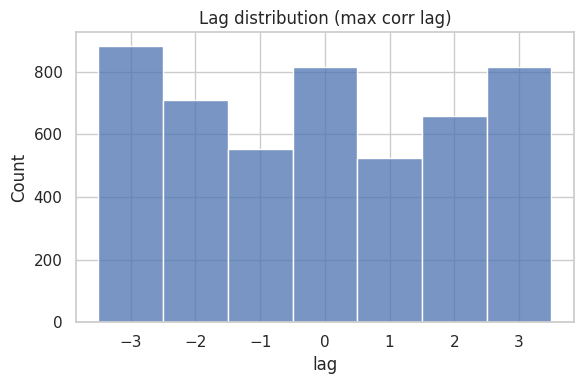

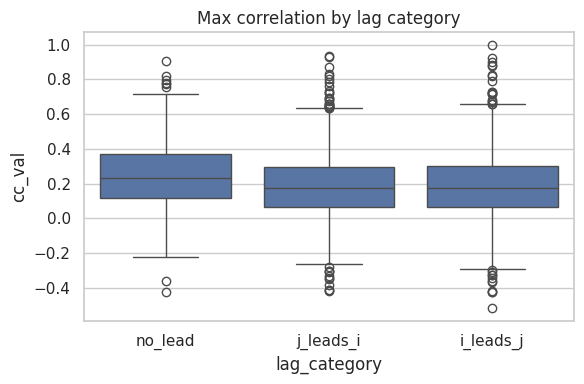

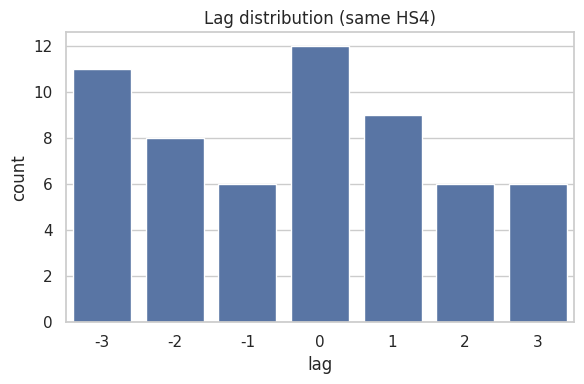

In [9]:
# ============================================================
# 7. EDA for W4 (Cross-correlation lag)
# ============================================================

plt.figure(figsize=(6, 4))
sns.histplot(pair_df["lag_val"], discrete=True)
plt.title("Lag distribution (max corr lag)")
plt.xlabel("lag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# lag>0 (i leads j), lag<0 (j leads i), lag=0
pair_df["lag_category"] = np.where(
    pair_df["lag_val"] > 0, "i_leads_j",
    np.where(pair_df["lag_val"] < 0, "j_leads_i", "no_lead")
)

plt.figure(figsize=(6, 4))
sns.boxplot(x="lag_category", y="cc_val", data=pair_df)
plt.title("Max correlation by lag category")
plt.tight_layout()
plt.show()

# HS4 내부 lag 구조
plt.figure(figsize=(6, 4))
sns.countplot(x="lag_val", data=pair_df[pair_df["same_hs4"] == 1])
plt.title("Lag distribution (same HS4)")
plt.xlabel("lag")
plt.tight_layout()
plt.show()




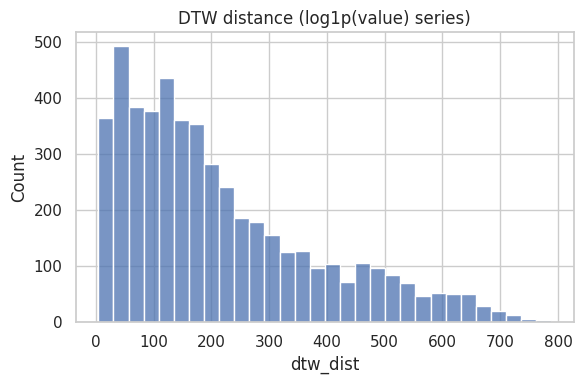

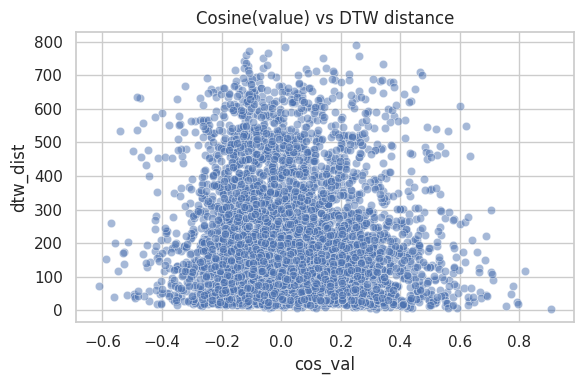

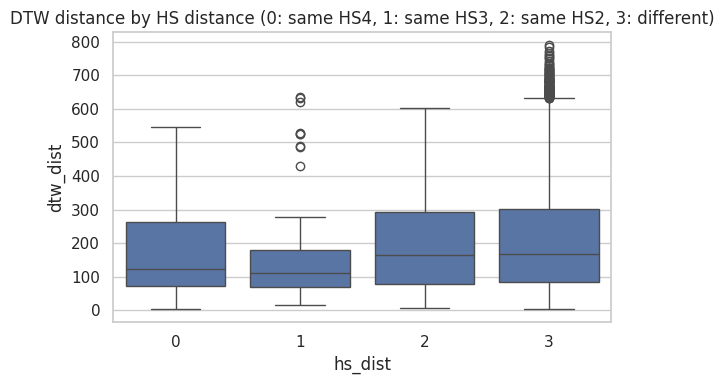

In [10]:
# ============================================================
# 8. EDA for W5 (DTW similarity)
# ============================================================

plt.figure(figsize=(6, 4))
sns.histplot(pair_df["dtw_dist"], bins=30)
plt.title("DTW distance (log1p(value) series)")
plt.xlabel("dtw_dist")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x="cos_val", y="dtw_dist", data=pair_df, alpha=0.5)
plt.title("Cosine(value) vs DTW distance")
plt.xlabel("cos_val")
plt.ylabel("dtw_dist")
plt.tight_layout()
plt.show()

# HS-level DTW distance
plt.figure(figsize=(6, 4))
sns.boxplot(x="hs_dist", y="dtw_dist", data=pair_df)
plt.title("DTW distance by HS distance (0: same HS4, 1: same HS3, 2: same HS2, 3: different)")
plt.xlabel("hs_dist")
plt.tight_layout()
plt.show()




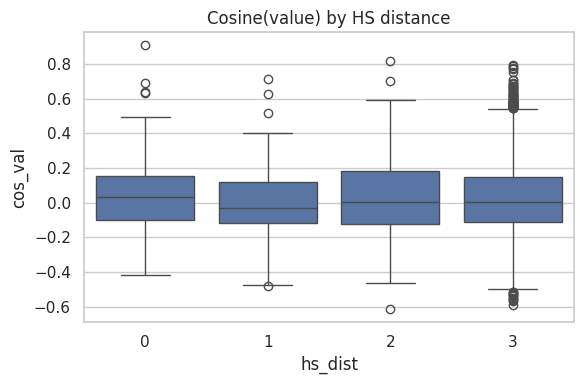

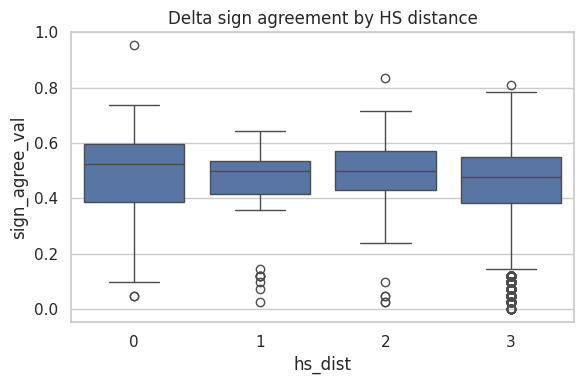

In [11]:
# ============================================================
# 9. EDA for W6 (HS distance structure)
# ============================================================

plt.figure(figsize=(6, 4))
sns.boxplot(x="hs_dist", y="cos_val", data=pair_df)
plt.title("Cosine(value) by HS distance")
plt.xlabel("hs_dist")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x="hs_dist", y="sign_agree_val", data=pair_df)
plt.title("Delta sign agreement by HS distance")
plt.xlabel("hs_dist")
plt.tight_layout()
plt.show()




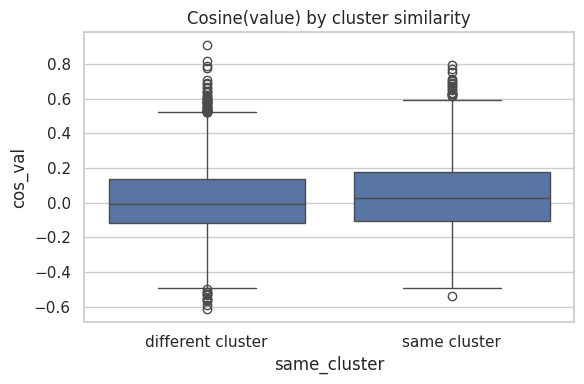

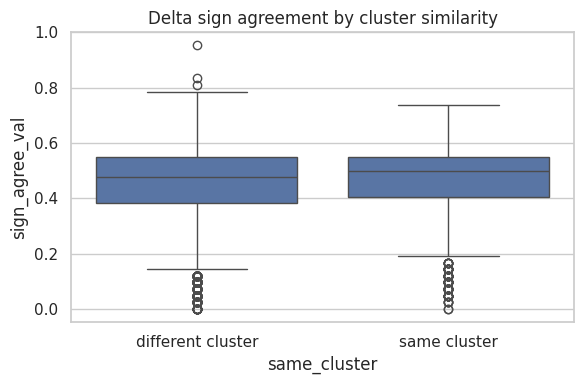

[INFO] Step2 pairwise EDA finished.


In [12]:
# ============================================================
# 10. EDA for W7 (Cluster similarity, if available)
# ============================================================

if "cluster_wv" in item_meta.columns and not pair_df["same_cluster"].isna().all():
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="same_cluster", y="cos_val", data=pair_df)
    plt.title("Cosine(value) by cluster similarity")
    plt.xticks([0, 1], ["different cluster", "same cluster"])
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x="same_cluster", y="sign_agree_val", data=pair_df)
    plt.title("Delta sign agreement by cluster similarity")
    plt.xticks([0, 1], ["different cluster", "same cluster"])
    plt.tight_layout()
    plt.show()

print("[INFO] Step2 pairwise EDA finished.")


In [13]:
# 가장 유용한 것

# Cosine(value) — weak but meaningful

# Sign agreement — independent weak signal

# Cross-correlation amplitude(cc_val) — cos보다 낫지만 lag 중요도는 낮음

# 보조 신호

# Cluster similarity — HS보다 훨씬 나음

# HS distance — 약한 보조 신호

# 조심해야 할 것

# DTW — 단독 사용은 절대 비추 (noise 강함) → 가중치는 매우 작게